In [27]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using GraphIO 
using ParserCombinator 
using PlotlyJS
using JLD2, DelimitedFiles

In [19]:
splg_methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS"
    "iid JL-LS",
    #"iid LS",
    "ST JL-LS",
    # "ST LS",
]

# simulation parameters
n_batch = 6 # maximum batch size considered
n_rep = 3 # number of runs

3

#### loading ploblogs

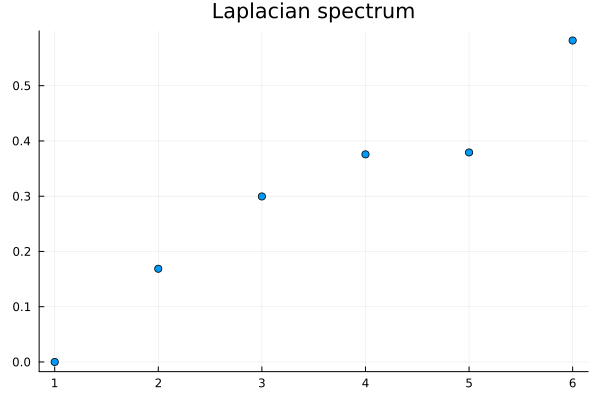

In [17]:
real_g = "polblogs.gml"
g = loadgraph(real_g, "digraph", GraphIO.GML.GMLFormat())
g = SimpleGraph(g)

rng = Random.default_rng()

# select largest connected component
temp = connected_components(g)
g = g[temp[1]]

meta_g = MetaGraph(g)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

### plotting Laplacian spectrum

B = sp_magnetic_incidence(meta_g)
Lap = B' * B
Lap = 0.5 * (Lap + Lap')

l,_ = eigs(Lap; nev=6, which=:SM)

Plots.scatter(1:6,sort(real.(l));legend=false,title="Laplacian spectrum")

In [20]:
# regularization parameter
q = 0.01

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "precond_PolBlogs_"*"q"*string(q)
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)

cond nb of Laplacian: 35205.57120411233
k = 

393 vs nb edges= 16717
 
k = 

393 vs nb edges= 16717
 
method: DPP(K) unifmethod: 

DPP(K) JL-LSmethod: 

iid JL-LSmethod: 

ST JL-LS

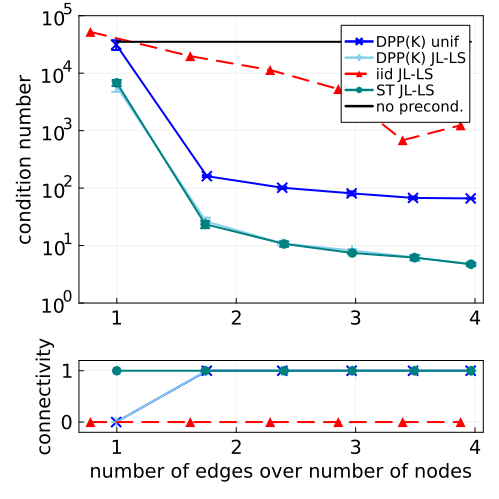

In [25]:
# loading results
load("figures/data/"*name*"_data.jld2")
# plotting
y_limits = (1,1e5)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
# Plots.savefig("figures/"*name*".pdf")

## Epinions

#### loading Epinions

In [28]:
list = readdlm("soc-Epinions1.txt")
mist = list .+ 1 # s.t. indices start at 1

list_tuple = Array(tuple.(eachcol(Int.(list))...))
e_list = Edge.(list_tuple)
meta_g = SimpleGraphFromIterator(e_list)

meta_g = main_component(meta_g)
meta_g = SimpleGraph(meta_g)
n = nv(meta_g)
m = ne(meta_g)
println("n= ",n)
println("m= ",m)

n= 75869
m= 405057


### MUN Epinions

loading


In [29]:
rng = Random.default_rng()

model = :mun
eta = 0.05
planted_score = randperm(rng,n)

meta_g = turn_into_connection_graph(rng,meta_g,eta,model,planted_score)

{75869, 405057} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

### Computing sampling times

In [31]:
n_rep = 100
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up (precompilation)
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

println([mean(time_crsf) mean(time_st)])

# storing settings
D_params = Dict("model" => model,"eta" => eta,"n_rep" =>  n_rep)
name = "MUN_time_epinions_"*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

[0.61066701314 0.8322194010499999]


### plotting sampling times

In [32]:
load("figures/data/"*name*"_data.jld2")

trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)


trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
plt_MUN = PlotlyJS.plot([trace_crsf, trace_st],layout)

PlotlyJS.savefig(plt_MUN,"figures/"*name*".pdf")

"figures/MUN_time_epinions_eta0.05q0.pdf"

### MUN Epinions precond

In [33]:
# simulation parameters
n_batch = 6 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "MUN_precond_epinions_"*"eta"*string(eta)*"q"*string(q)


In [ ]:
save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)


In [ ]:
load("figures/data/"*name*"_data.jld2")
# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
Plots.savefig("figures/"*name*".pdf")

### ERO Epinions

loading

In [ ]:
rng = Random.default_rng()

model = :ero
eta = 2*1e-5
planted_score = randperm(rng,n)

meta_g = turn_into_connection_graph(rng,meta_g,eta,model,planted_score)

### Computing sampling time

In [13]:
n_rep = 100
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end


println([mean(time_crsf) mean(time_st)])


# storing settings
D_params = Dict("model" => model,"eta" => eta,"n_rep" =>  n_rep)
name = "ERO_time_epinions_"*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2", "time_crsf", time_crsf,"time_st", time_st ,"D_params", D_params)

[0.48624524562000004 0.4974504423600001]


### Plotting sampling time

In [ ]:
trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)


trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group",
    showlegend=false
)
plt_ERO =PlotlyJS.plot([trace_crsf, trace_st],layout)

name = "ERO_time_epinions_"*"eta"*string(eta)*"q"*string(q)
PlotlyJS.savefig(plt_ERO,"figures/"*name*".pdf")

### ERO Epinions precond

cond nb of Laplacian: 1.0497319355336212e7
method: DPP(K) unifmethod: 

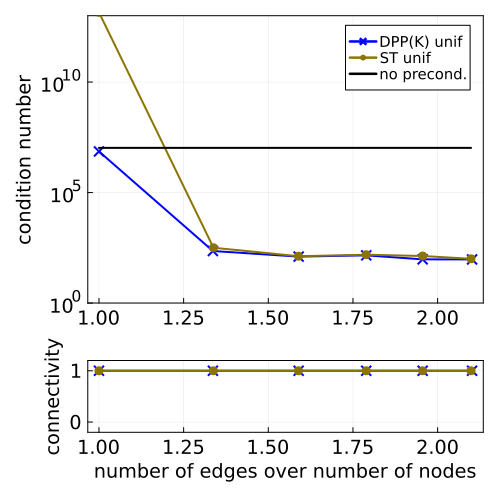

ST unif

"/Users/mfanuel/Documents/Code/juliaTemplate/MagneticLaplacianSparsifier/notebooks/figures/ERO_precond_epinions_eta2.0e-5q0.pdf"

In [48]:
# simulation parameters
n_batch = 6 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "ERO_precond_epinions_"*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2", "D_results", D_results,"D_params", D_params)


In [ ]:
load("figures/data/"*name*"_data.jld2")

y_limits = (1,1e13)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
Plots.savefig("figures/"*name*".pdf")

## pokec

In [55]:
list = readdlm("soc-pokec-relationships.txt")
mist = list .+ 1 # s.t. indices start at 1

list_tuple = Array(tuple.(eachcol(Int.(list))...))
e_list = Edge.(list_tuple)
meta_g = SimpleGraphFromIterator(e_list)

meta_g = main_component(meta_g)
meta_g = SimpleGraph(meta_g)
n = nv(meta_g)
m = ne(meta_g)
println("n= ",n)
println("m= ",m)

n= 1632803
m= 22301964


In [56]:
rng = Random.default_rng()
# select largest connected component

model = :mun
eta = 0.05
planted_score = randperm(rng,n)

meta_g = MetaGraph(meta_g)
for e in edges(meta_g)
    u = src(e)
    v = dst(e)
    h_u = planted_score[u]
    h_v = planted_score[v]
    θ = (h_u - h_v) * π / (n - 1)
    if (model === :ero) && (rand(rng) < eta) # Erdos-Renyi Outliers
        θ = rand(rng, (-n + 1):(n - 1)) * π / (n - 1)
    elseif model === :mun # Multiplicative Uniform Noise
        θ *= 1.0 + eta * 2 * (rand(rng) - 0.5)
    end
    set_prop!(meta_g, e, :angle, θ)
end


using PlotlyJS

n_rep = 3
time_crsf = zeros(n_rep)
time_st = zeros(n_rep)

q = 0                    
absorbing_node = true
ust = true
weighted = false

# warm up
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)

for i_rep = 1:n_rep
    vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    vec_st = @timed multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
    time_crsf[i_rep] = vec_crsf[2]
    time_st[i_rep] = vec_st[2]
end

trace_crsf = box(y=time_crsf,
quartilemethod="linear",
name="CRSF",
boxmean=true)


trace_st = box(y=time_st,
quartilemethod="linear",
name="ST",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
    boxmode="group"
)
plt_pokec =PlotlyJS.plot([trace_crsf, trace_st],layout)

eta = eta 
name = "ERO_time_epinions_"*"eta"*string(eta)*"q"*string(q)
# PlotlyJS.savefig(plt_pokec,"figures/"*name*".pdf")

println([mean(time_crsf) mean(time_st)])


In [38]:


# simulation parameters
n_batch = 3 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

splg_methods = [
    "DPP(K) unif",
    # "DPP(K) JL-LS",
    #"DPP(K) LS"
    # "iid JL-LS",
    # "iid LS",
    # "ST JL-LS",
    # "ST LS",
    # "ST JL-LS"
    "ST unif",
]

# compute condition numbers
D_results = cond_numbers(meta_g,q,n_batch,n_rep,rng;splg_methods)
name = "MUN_precond_epinions_"*"q"*string(q)

# plotting
y_limits = (1,1e9)
plot_comparison_cond(D_results,y_limits;legendposition=:topright,splg_methods)

# saving plot
# Plots.savefig("figures/"*name*".pdf")

InterruptException: InterruptException: